In [1]:
import os
os.chdir('../../') #if we are in notebooks folder

In [17]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
from flax.core.frozen_dict import freeze, unfreeze
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import sin_data
from utilities import plot

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import blackjax

In [7]:
class MLP(nn.Module):
    features : list
        
    @nn.compact
    def __call__(self, X):
        for i, feature in enumerate(self.features):
            X = nn.Dense(feature, kernel_init=jax.nn.initializers.glorot_normal(), name=f"Dense_{i}")(X)
            X = nn.relu(X)            
        X = nn.Dense(1, name=f"Dense_{i+1}")(X)
        return X.flatten()

    def loss_fn(self, params, X, y):
        y_hat = self.apply(params, X)
        @jax.jit
        def binary_cross_entropy(params,y_hat, y):
            bce = y * jnp.log(y_hat) + (1 - y) * jnp.log(1 - y_hat)
            return jnp.mean(-bce)
        return jnp.mean(jax.vmap(binary_cross_entropy, in_axes=(None, 0, 0))(params,y_hat, y))

## Load Dataset

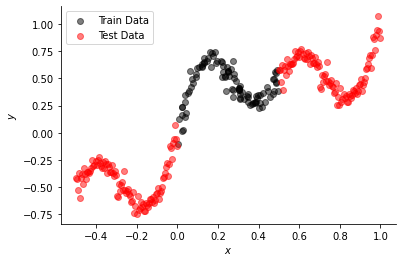

In [8]:
X,Y,x_test_1,y_test_1,x_test_2,y_test_2 = sin_data.load_data()
Y = Y.flatten()
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

In [9]:
model = MLP([32,32,1])
model.tabulate(jax.random.PRNGKey(5),X)

                     MLP Summary                      
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs         ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[100,1]  │                        │
├─────────┼─────────────────┼────────────────────────┤
│ Dense_0 │ float32[100,32] │ bias: float32[32]      │
│         │                 │ kernel: float32[1,32]  │
│         │                 │                        │
│         │                 │ 64 (256 B)             │
├─────────┼─────────────────┼────────────────────────┤
│ Dense_1 │ float32[100,32] │ bias: float32[32]      │
│         │                 │ kernel: float32[32,32] │
│         │                 │                        │
│         │                 │ 1,056 (4.2 KB)         │
├─────────┼─────────────────┼────────────────────────┤
│ Dense_2 │ float32[100,1]  │ bias: float32[1]       │
│         │                 │ kernel: float32[32,1]  │
│         │                 │                        │
│         │                 │ 33 (132 B)             │
├─────────┼─────────────────┼────────────────────────┤
│ Dense_3 │ float32[100,1]  │ bias: float32[1]       │
│         │                 │ kernel: float32[1,1]   │
│         │                 │                        │
│         │                 │ 2 (8 B)                │
├─────────┼─────────────────┼────────────────────────┤
│ MLP     │ float32[100]    │                        │
├─────────┼─────────────────┼────────────────────────┤
│         │           Total │ 1,155 (4.6 KB)         │
└─────────┴─────────────────┴────────────────────────┘
                                                      
           Total Parameters: 1,155 (4.6 KB)           

'\n\n'

In [10]:
rng_key  = jax.random.PRNGKey(0)
init_params = unfreeze(model.init(rng_key, x_test_1))
jax.tree_structure(init_params)

PyTreeDef({'params': {'Dense_0': {'bias': *, 'kernel': *}, 'Dense_1': {'bias': *, 'kernel': *}, 'Dense_2': {'bias': *, 'kernel': *}, 'Dense_3': {'bias': *, 'kernel': *}}})

In [13]:
prior = jax.tree_map(lambda x: tfd.Independent(tfd.Normal(loc=jnp.zeros(x.shape), scale=jnp.ones(x.shape)), 
                                               reinterpreted_batch_ndims=len(x.shape)) ,init_params)

def log_prior_fn(params):
    log_prior = jax.tree_map(lambda dist, sample: dist.log_prob(sample), prior, params, 
                             is_leaf=lambda x: isinstance(x,tfd.Distribution))
    
    log_prior = sum(jax.tree_leaves(log_prior))
    return log_prior

In [14]:
def log_likeli_fn(params, data, aux):
    return tfd.Normal(loc = model.apply(params, aux), scale=0.1).log_prob(data).sum()

def log_joint_fn(params, data, aux):
    return log_prior_fn(params) + log_likeli_fn(params, data, aux)

In [15]:
from functools import partial

In [16]:
log_joint_partial_fn = partial(log_joint_fn, data=Y, aux=X)
log_joint_partial_fn(init_params)

DeviceArray(-2028.3411, dtype=float32)

In [18]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state,info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states,infos) = jax.lax.scan(one_step, initial_state, keys)

    return (states, infos)

In [19]:
%%time
rng_key = jax.random.PRNGKey(1)

# fix other args excepgt params
log_joint_partial_fn = partial(log_joint_fn, data=Y, aux=X)

# warm up
num_warmup = 500
adapt = blackjax.window_adaptation(blackjax.nuts, log_joint_partial_fn, num_warmup)
final_state, kernel, _ = adapt.run(rng_key, init_params)

# actual sampling
n_samples = 1000
states, infos = inference_loop(jax.random.PRNGKey(2), kernel, final_state, n_samples)

CPU times: user 1min 33s, sys: 324 ms, total: 1min 34s
Wall time: 1min 33s


In [20]:
samples = states.position
samples["params"]["Dense_2"]["kernel"].shape

(1000, 32, 1)

In [21]:
params_mean =  jax.tree_map(lambda x: x.mean(axis=0),samples)
params_std = jax.tree_map(lambda x: x.std(axis=0),samples)

In [22]:
params_mean

{'params': {'Dense_0': {'bias': DeviceArray([-0.09991582,  0.00367631, -0.10131867,  0.13043043,
                -0.00321198, -0.29116967, -0.19916674,  0.11013244,
                -0.01582798,  0.15865561,  0.10528372,  0.3622597 ,
                -0.0353026 ,  0.0254651 , -0.13762397, -0.1800643 ,
                -0.06034436,  0.03259763, -0.04671262,  0.04263754,
                 0.01050191, -0.07499246,  0.17323452,  0.12986085,
                 0.06073171,  0.05940858,  0.1703859 , -0.2142023 ,
                 0.07033056, -0.26758882,  0.09565533,  0.04490987],            dtype=float32),
   'kernel': DeviceArray([[-0.18248162,  0.00999141, -0.05850589, -0.12638918,
                  0.032593  , -0.08059091, -0.00918763,  0.03151843,
                  0.02890351, -0.01785107,  0.1698252 ,  0.14782815,
                 -0.04139199, -0.14465915, -0.07969263,  0.08765681,
                  0.03135355, -0.14053117, -0.03565577,  0.0589017 ,
                  0.01196192,  0.13454886,  

## Prediction

In [23]:
y_preds = jax.vmap(lambda params: model.apply(params,X))(samples)
y_preds.shape

(1000, 100)

In [24]:
X_sorted_train = jnp.sort(X.reshape(-1))
Y_sorted_train = jnp.sort(Y)

In [25]:
X_sorted_train.shape, Y_sorted_train.shape

((100,), (100,))

In [26]:
x_stack =jnp.concatenate([x_test_1.reshape(-1),X_sorted_train,x_test_2.reshape(-1)],axis=0)
y_stack = jnp.concatenate([y_test_1.reshape(-1),Y_sorted_train,y_test_2.reshape(-1)],axis=0)
x_stack.shape, y_stack.shape

((300,), (300,))

In [27]:
Y_stack_pred = jax.vmap(lambda params: model.apply(params,x_stack.reshape(-1,1)))(samples)#.mean(axis=0)
Y_stack_pred.shape

(1000, 300)

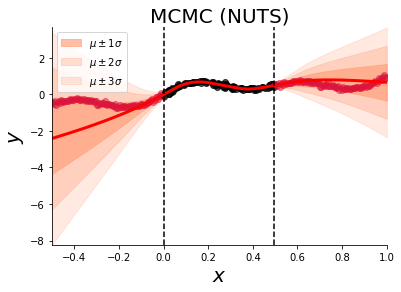

In [28]:
plot.plot_prediction(X,Y,x_stack,y_stack,Y_stack_pred.mean(axis=0),Y_stack_pred.std(axis=0),'MCMC (NUTS)')

Text(0.5, 1.0, 'MCMC (NUTS)')

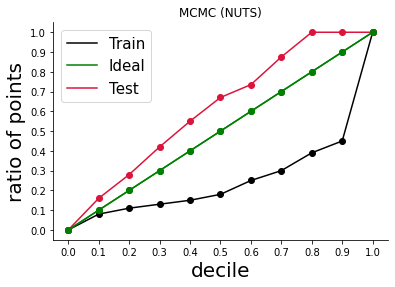

In [29]:
fig, ax =  plt.subplots()
plot.calibration_reg(Y_stack_pred.mean(axis=0), Y_stack_pred.std(axis=0)+0.1,y_stack, ax = ax)
ax.set_title("MCMC (NUTS)")